In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
import torch.optim as optim
import os
import openpyxl
from torch.utils.data import TensorDataset, DataLoader,random_split
#import tensorflow as tf

df = pd.read_excel("Data for headed bars_for DataFrame_220725.xlsx", skiprows = 17, engine = 'openpyxl', sheet_name= 'headed (2)' )
df = pd.DataFrame(df, columns = ["No.", "Author", "Year", "Test type", "Remark", "Specimen", "fy", "Ld", "fcm", "db", "b", "cos,avg",
                                 "cth", "ch", "Nh", "Bottom cover", "Ah/Ab", "Fsu at La, test", "dtr", "Ntr", "st"]) # st 제거시

df = df[df["Test type"] == "Joint type"]
y= df["Fsu at La, test"] 

pd.set_option('display.max_rows',None)

y2=y[~y.isnull()]
X = df[["Test type", "fy", "Ld", "fcm", "db", "b", "cos,avg", "cth", "ch", "Nh", "Bottom cover", "Ah/Ab", "st"]] 

X = pd.get_dummies(data = X, columns = ["Test type"], prefix = "Test_type")
X = X[~y.isnull()]

pd.options.display.max_rows = None
X.dropna(inplace = True)

y2 = y2[X.index]
y2 = y2.loc[(y2 != 0)] # series
X = X.loc[y2.index] # DataFrame

* train, test 분류

In [9]:
#test, train+valid 분류
from sklearn.model_selection import train_test_split
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.20, random_state=142)

* 분류한 데이터 스케일링 후 텐서로 변환

In [10]:
# 분류한 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler
scX = MinMaxScaler() #형태는 넘파이
x_train_scaled = scX.fit_transform(X_train)   
x_test_scaled = scX.transform(X_test)

scY = MinMaxScaler()
y_train_scaled = scY.fit_transform(y_train.values.reshape(-1,1)) 
y_test_scaled = scY.transform(y_test.values.reshape(-1,1))

#스케일링->텐서로
x_test_tensor = torch.FloatTensor(x_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)
x_train_tensor = torch.FloatTensor(x_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)

* 파이토치 이용한 모델 구현

In [11]:
#데이터 모델 클래스로 구현
class TorchModel(nn.Module):
    def __init__(self):
        super(TorchModel, self).__init__()
        self.layer = nn.Linear(13, 1)

    def forward(self, x):
        return self.layer(x)
    
#커스텀 데이터 셋
class CustomDataset(TensorDataset): 
    def __init__(self):
        self.x = x_train_tensor
        self.y = y_train_tensor
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])
        y = torch.FloatTensor(self.y[idx]) 
        return x, y
    
    def __len__(self): 
        return len(self.x)

#데이터 셋에서 train, validation 나누기 
dataset = CustomDataset()
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = dataset_size - train_size

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")

# 데이터 로더
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True)

Training Data Size : 172
Validation Data Size : 44


학습

In [12]:

train_losses = []
val_losses = []
train_acc = []
val_acc = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TorchModel().to(device)
criterion = nn.MSELoss().to(device) #
optimizer = torch.optim.Adam(model.parameters(), lr = 0.03) #
nb_epochs = 1000

# 모델 학습
for epoch in range(nb_epochs+1):
    train_loss = 0       
    train_accuracy = 0
    accuracy = 0
    for _,data in enumerate(train_dataloader):
        x,y =data
        x = x.to(device)
        y_train = y.to(device)
        p_train = model(x)
        train_cost =criterion(p_train, y_train)
        
        optimizer.zero_grad()
        train_cost.backward()
        optimizer.step()
        
        train_loss += train_cost.item()
      
    # 모델 검증
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for _,data in enumerate(validation_dataloader):
            x,y = data
            x = x.to(device)
            y_val = y.to(device)
            p_val = model(x)
            val_cost = criterion(p_val, y_val)
            
            val_loss += val_cost.item()
           
    # calculate mean for each batch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(validation_dataloader))
   
    if epoch % 100== 0:
        print("Epoch:{:4d}/{}".format(epoch, nb_epochs),
              "Train Loss: {:.6f}".format(train_loss / len(train_dataloader)),
              "Val Loss: {:.6f}".format(val_loss / len(validation_dataloader)))
              

history = {'train_loss': train_losses, 'val_loss': val_losses,
            'y_train':y_train,'p_train': p_train ,'y_val': y_val, 'p_val':p_val}

Epoch:   0/1000 Train Loss: 0.186660 Val Loss: 0.077306
Epoch: 100/1000 Train Loss: 0.011336 Val Loss: 0.015624
Epoch: 200/1000 Train Loss: 0.012885 Val Loss: 0.018137
Epoch: 300/1000 Train Loss: 0.011406 Val Loss: 0.017104
Epoch: 400/1000 Train Loss: 0.011318 Val Loss: 0.017734
Epoch: 500/1000 Train Loss: 0.011677 Val Loss: 0.018396
Epoch: 600/1000 Train Loss: 0.011770 Val Loss: 0.017239
Epoch: 700/1000 Train Loss: 0.012369 Val Loss: 0.017787
Epoch: 800/1000 Train Loss: 0.012936 Val Loss: 0.017350
Epoch: 900/1000 Train Loss: 0.011013 Val Loss: 0.017692
Epoch:1000/1000 Train Loss: 0.011657 Val Loss: 0.020382


(<matplotlib.legend.Legend at 0x7f1d5a9aacd0>, None)

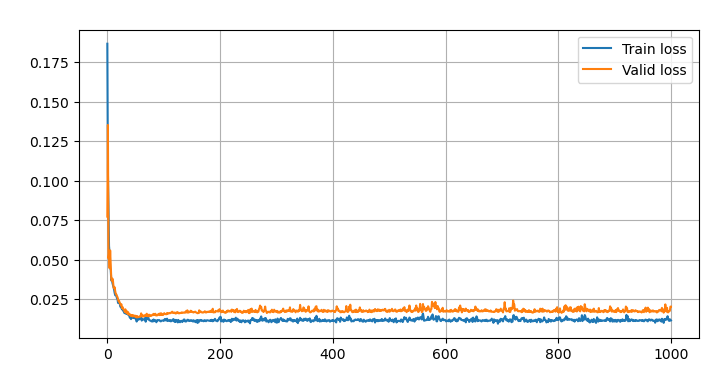

In [13]:
plt.figure(figsize = (8,4))
plt.plot(history['train_loss'],label = "Train loss")
plt.plot(history['val_loss'],label = "Valid loss")
plt.title(f'Loss', color='white', fontweight = 'bold')
plt.ylabel('Loss', color='white')
plt.xlabel('epoch', color='white')
plt.legend(), plt.grid()

평가

GPU 사용시 .to(device)로 tensor를 cpu로 바꿔줘야 numpy 등에서 인식가능

In [27]:
x_test_tensor = x_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)
x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

In [28]:
p_test = model(x_test_tensor)
p_test[:10], y_test_scaled[:10]

(tensor([[0.0048],
         [0.3689],
         [0.4600],
         [0.4053],
         [0.4578],
         [0.2270],
         [0.5899],
         [0.3654],
         [0.5453],
         [0.2803]], device='cuda:0', grad_fn=<SliceBackward0>),
 array([[0.00630971],
        [0.61743428],
        [0.41448432],
        [0.3316623 ],
        [0.50594864],
        [0.37568401],
        [0.65718885],
        [0.52827458],
        [0.81275021],
        [0.24812009]]))

In [29]:
p_test

tensor([[0.0048],
        [0.3689],
        [0.4600],
        [0.4053],
        [0.4578],
        [0.2270],
        [0.5899],
        [0.3654],
        [0.5453],
        [0.2803],
        [0.4153],
        [0.5426],
        [0.4162],
        [0.1881],
        [0.0942],
        [0.1161],
        [0.0129],
        [0.2881],
        [0.4550],
        [0.6037],
        [0.6176],
        [0.6362],
        [0.3689],
        [0.2741],
        [0.5018],
        [0.6268],
        [0.6212],
        [0.1082],
        [0.1853],
        [0.6949],
        [0.0947],
        [0.3957],
        [0.1596],
        [0.2108],
        [0.1673],
        [0.5496],
        [0.4385],
        [0.5573],
        [0.0939],
        [0.5211],
        [0.5112],
        [0.4141],
        [0.3640],
        [0.5080],
        [0.3011],
        [0.3319],
        [0.4744],
        [0.5912],
        [0.7166],
        [0.1932],
        [0.6937],
        [0.5989],
        [0.4079],
        [0.4161]], device='cuda:0', grad_fn=<A

In [33]:
print(type(y_test_scaled))

<class 'numpy.ndarray'>


In [34]:
y_test_unscaled = scY.inverse_transform(y_test_scaled)  
print(len(y_test_unscaled),y_test_unscaled, type(y_test_unscaled))

p_test_unscaled = scY.inverse_transform(p_test.cpu().detach().numpy()) # numpy로 만들기 위해 .cpu()로 변환
print(len(p_test_unscaled),p_test_unscaled)

54 [[ 118.78727634]
 [ 704.        ]
 [ 509.65517241]
 [ 430.34482759]
 [ 597.24137931]
 [ 472.5       ]
 [ 742.06896552]
 [ 618.62068966]
 [ 891.03448276]
 [ 350.34482759]
 [ 540.        ]
 [ 661.37931034]
 [ 759.31034483]
 [ 189.65517241]
 [ 337.77148436]
 [ 367.        ]
 [ 346.71249424]
 [ 416.55172414]
 [ 550.        ]
 [ 892.4137931 ]
 [ 967.5862069 ]
 [ 951.72413793]
 [ 707.        ]
 [ 354.48275862]
 [ 657.93103448]
 [ 726.89655172]
 [ 907.5862069 ]
 [ 382.47653376]
 [ 312.5       ]
 [ 698.62068966]
 [ 354.66005857]
 [ 291.72413793]
 [ 417.        ]
 [ 275.86206897]
 [ 413.27334556]
 [ 626.89655172]
 [ 777.93103448]
 [ 623.44827586]
 [ 269.22374194]
 [ 544.82758621]
 [ 686.89655172]
 [ 534.48275862]
 [ 391.03448276]
 [ 687.5862069 ]
 [ 349.65517241]
 [ 446.89655172]
 [ 586.        ]
 [ 947.5862069 ]
 [1040.68965517]
 [ 320.68965517]
 [ 760.68965517]
 [ 843.44827586]
 [ 388.27586207]
 [ 538.7723909 ]] <class 'numpy.ndarray'>
54 [[117.325874]
 [465.9838  ]
 [553.2531  ]
 [500.891

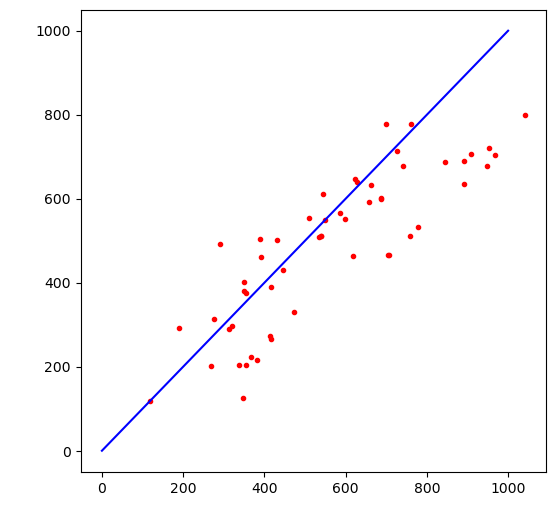

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(y_test_unscaled, p_test_unscaled, 'r.')
ax.set_xlabel("Tested tensile stress, ft_test (MPa)", fontsize = 14,color = 'white')
ax.set_ylabel("Predicted tensile stress, ft_pred (MPa)", fontsize = 14, color = 'white')
x = np.linspace(0, 1000, 100)
y = x
ax.plot(x, y, 'b')
fig.show()


In [36]:
x_test_unscaled = scX.inverse_transform(x_test_scaled)  
print(x_test_unscaled)

[[450.6        217.          24.6         35.8        220.
   92.1        205.           0.           1.         369.
    5.         217.           1.        ]
 [649.         127.2        129.9         31.8        396.
   31.8         43.8        268.8          2.          84.8
    5.         127.2          1.        ]
 [799.31034483 233.426       46.27586207  25.4        439.42
   66.04        82.55       256.54         2.         260.35
    5.5        233.426        1.        ]
 [889.65517241 304.8         83.03448276  25.4        378.46
   62.23        76.2         50.8          4.         260.35
    5.1        304.8          1.        ]
 [799.31034483 203.2         40.68965517  25.4        439.42
   67.31        86.36       254.           2.         260.35
    5.5         76.2          1.        ]
 [583.         573.          51.4         57.3        584.46
   57.3         56.         355.26         2.         289.
    5.         275.           1.        ]
 [799.31034483 358.902   

모델 평가

In [38]:
test_loss = 0
model.eval()
with torch.no_grad():
    for i in range(len(y_test_unscaled)):
        pred = model(x_test_tensor)
        cost = criterion(pred, y_test_tensor)
        test_loss += cost.item()
        
    print('test_loss:',test_loss)

test_loss: 1.1059761978685856


In [39]:
division = p_test_unscaled / y_test_unscaled
cov = np.std(division) / np.mean(division)
print(cov)

0.26276901982635453


In [40]:
from sklearn.metrics import r2_score
r2_score(y_test_unscaled, p_test_unscaled)

0.6135658069190386

## 테스트 정확도 

In [41]:
def total(y_test_unscaled, y_p_unscaled, tol = 50):    # tolerance = 50인 이유는? 이것은 추후 활용할 것. 일단 R2 score 와 cov(coefficient of variance)로 평가 가능.
    return abs(y_test_unscaled - y_p_unscaled) <= tol
test_loss = 0
accuracy = 0
wrong = 0
w=[]
model.eval()
with torch.no_grad():
    for i in range(len(y_test_unscaled)):
        pred = model(x_test_tensor)
        cost = criterion(pred, y_test_tensor)
        test_loss += cost.item()
        if total(p_test_unscaled[i], y_test_unscaled[i]):
            accuracy +=1
        else:
            wrong +=1
    test_accuracy = accuracy /len(p_test_unscaled) 
    print('test_loss:',test_loss)
    print(f'test_acc:{test_accuracy:.5f}')

test_loss: 1.1059761978685856
test_acc:0.37037


1. 여기에 기계학습 방법 외에 다른 통계학습 방법과 이들을 활용하여 예측한 결과
1) 의사결정나무
2) 서포트벡터머신
3) 그 외 다른 방법 통계학습 방법

In [ ]:
2. 기존 설계기준식들을 활용하여 예측한 결과

3. 1, 2 결과와 비교하여 성능이 우수함을 입증하여야 함.

4. 그러기 위해서는 기존 기계학습 방법을 시행착오를 거쳐 성능을 향상시켜야 함.